# SVM Star-Quasar Classifier

This code is adapted from Sumin Tang's old GitHub page:
    https://github.com/tangsm/SVM-quasars/blob/master/SVM_quasar_search.py

**Aim**: Identify quasars behind M31 with SVM linear model, including
    1. Formatting the data
    2. Feature visualization
    3. Feature selection & parameter tuning in classifiers
    4. Classification

**-- Input file (data.fits)**: A table in fits format that contains information for 18603 light curves, including
    * RA, DEC,  
    * 40 features,  
    * group index (i.e., if SDSS and/or WISE data are available),  
    * lable index (1=known quasar, 0=known star, -1=unknown)  
  
-- Output file:
    

In [1]:
%pylab inline
import os
import time
import pylab
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn import svm
from sklearn import metrics
from sklearn import feature_selection
from sklearn import cross_validation
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Populating the interactive namespace from numpy and matplotlib


/Users/yaoyuhan/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Part 1. Formatting the data

In [2]:
basedir = os.getcwd() + "/"
data_ = fits.open(basedir+'data.fits')[1].data
ind1 = data_['group']==1 
print "@Yao: Analyze Group 1 (with both SDSS and WISE data)..."
data = data_[ind1] 
nrow = len(data['RA'])
featurenames = ['A','gamma','ltau','lvar',
                'MedianMag','rMeanMedian','MedianAbsDev','lcstd',
                'lcstd1','lcstd3','lcstd5','nr1','nr3','nr5',
                'nra1','nrb1','nrca1','nrcb1',
                'nrcf1','nrcf3','nrcf5','lcamp',
                'lcamp1','lcamp3','lcamp5','chi2',
                'chi2_1','chi2_5','s','k',
                'rmsratio','ts5','ts1','nall',
                'umg_sdss','W1mW2','gmr_pst','rmi_pst','imz_pst','zmy_pst']

@Yao: Analyze Group 1 (with both SDSS and WISE data)...


In [3]:
X_data = np.zeros((nrow, len(featurenames)))
for i in range(len(featurenames)):
    ftname = featurenames[i]
    datacolumn = data[ftname]
    assert np.sum(np.isnan(datacolumn))<20
    datacolumn[np.isnan(datacolumn)] = 0
    X_data[:,i] = datacolumn
    xmean = np.mean(datacolumn)
    xstd = np.std(datacolumn)
    if xstd<0.01:
        xstd = 1.
    X_data[:,i] = (datacolumn - xmean)/xstd

In [4]:
print "@Yao: %d labeled + unlabeled objects,\n\t%d features." %(X_data.shape[0],X_data.shape[1])
#print X_data.mean(axis=0)
#print X_data.std(axis=0)

@Yao: 6182 labeled + unlabeled objects,
	40 features.


In [5]:
print "@Yao: Format labeled objects..."
myflag = data['lable']
label_qso_ind = myflag==1
print "%d labeled quasars" %np.sum(label_qso_ind) 
label_star_ind = myflag==0
print "%d labeled stars" %np.sum(label_star_ind) 
X_labeled = np.vstack([X_data[label_qso_ind],
                       X_data[label_star_ind]])
Y_labeled = np.hstack([np.ones(np.sum(label_qso_ind)),
                       np.zeros(np.sum(label_star_ind))])
data_qso = data[label_qso_ind]
data_star = data[label_star_ind]

@Yao: Format labeled objects...
50 labeled quasars
131 labeled stars


In [6]:
print "@Yao: Format unlabeled objects..."
unlabel_ind = myflag==-1
print "%d unlabeled objects" %np.sum(unlabel_ind) 
X_unlabeled = X_data[unlabel_ind]

@Yao: Format unlabeled objects...
6001 unlabeled objects


## Part 2. Feature visualization

### 2.1 Linear Discrimination Analysis (LDA)

In [7]:
lda_model = LinearDiscriminantAnalysis(n_components=1)
lda_model.fit(X_labeled, Y_labeled)

/Users/yaoyuhan/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

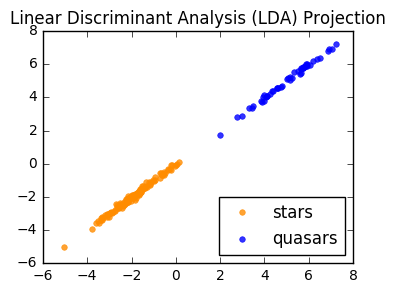

In [8]:
X_lda = lda_model.transform(X_labeled)
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ix = np.where(Y_labeled==0)[0]
ax.plot(X_lda[ix, 0], X_lda[ix, 0]+np.random.randn(len(ix))*0.1, '.', 
        color='darkorange', markersize=8, alpha=0.8, label='stars')
ix = np.where(Y_labeled==1)[0]
ax.plot(X_lda[ix, 0], X_lda[ix, 0]+np.random.randn(len(ix))*0.1, '.', 
        color='b', markersize = 8, alpha=0.8,label='quasars')
ax.legend(numpoints = 1, loc='lower right')
plt.title( "Linear Discriminant Analysis (LDA) Projection")

### 2.2 Plot the two most informative features

In [9]:
print "@Yao: Feature selection based on univariate feature selection..."
kfeature = 2
featureSelector = SelectKBest(score_func=feature_selection.f_classif,k=kfeature)

@Yao: Feature selection based on univariate feature selection...


In [10]:
featureSelector.fit(X_labeled,Y_labeled)
importances = featureSelector.scores_
indices = np.argsort(importances)[::-1]
ft1 = featurenames[indices[0]]
ft2 = featurenames[indices[1]]

In [11]:
print "Feature 1: %s;\nFeature 2: %s."%(ft1,ft2)

Feature 1: W1mW2;
Feature 2: ltau.


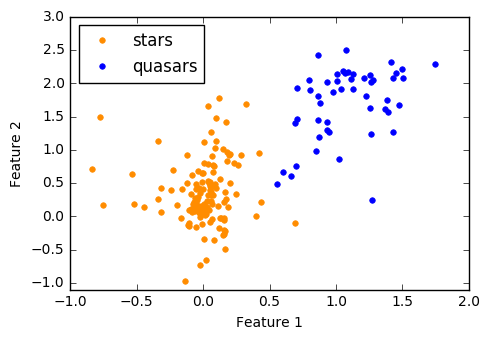

In [12]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111)
ax.plot(data_star[ft1], data_star[ft2], '.',color='darkorange', 
            markersize=8, label='stars')
ax.plot(data_qso[ft1], data_qso[ft2], '.', color='b',
            markersize=8, label='quasars')
ax.legend(numpoints = 1, loc='upper left')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_ylim([-1.1, 3.])
ax.set_xlim([-1., 2.])
plt.tight_layout()
plt.savefig(basedir +'2features.pdf')

## Part 3. Feature selection and parameter tuning in classifiers
We use recursive feature elimination with cross-validation (RFECV).
Create the RFE object and compute a cross-validated score.

In [13]:
t0 = time.time()
h = open(basedir + 'score-svmlinear.txt', 'w')
h.write("# iter_index, C, nfeature, score\n")

In [14]:
Cgrid = 10.**np.linspace(-2, 2, 11)
ncgrid = len(Cgrid)
niter = 20
featurerank = np.zeros((X_labeled.shape[1], ncgrid, niter))
print featurerank.shape 

(40, 11, 20)


In [15]:
for i in range(niter):
    cv = StratifiedKFold(n_splits=10, shuffle=True)    
    for ii in range(ncgrid):
        myc = Cgrid[ii]
        clf = svm.SVC(C = myc, kernel='linear', class_weight='balanced')
        rfecv = RFECV(estimator=clf, step=1, cv=cv, scoring='accuracy')
        rfecv.fit(X_labeled,Y_labeled)

        for j in range(len(rfecv.grid_scores_)):
            h.write("%d  %f  %i  %f\n" % (i, myc, j+1, rfecv.grid_scores_[j]))
            featurerank[j, ii, i] = rfecv.ranking_[j]

h.close()
t1 = time.time()
print "Time elapsed in feature selection (SVM Linear, %d iterations): %.2f s" % (niter, t1 - t0)

Time elapsed in feature selection (SVM Linear, 20 iterations): 215.73 s


In [16]:
print "Loading result..."
iter_ind, Cvalue, nfeature, score = np.loadtxt(basedir + 'score-svmlinear.txt', unpack=True, skiprows=1)

Loading result...


In [17]:
fn = np.linspace(1, int(max(nfeature))+1, int(max(nfeature)))
myscoresvm = np.zeros(len(fn))
mycvalue = np.zeros(len(fn))
myscorec = np.zeros(ncgrid)
for i in range(len(fn)):
    kfeature = i+1
    # select the best C value
    for j in range(len(Cgrid)):
        myc = Cgrid[j]
        ix = np.where((nfeature==kfeature)&(np.abs(Cvalue-myc)<myc*0.01))[0]
        myscorec[j] = np.mean(score[ix])
    iy = np.where(myscorec == np.max(myscorec))[0]
    myscoresvm[i] = np.max(myscorec)
    mycvalue[i] = np.mean(Cgrid[iy])

In [18]:
ix=np.where(myscoresvm==np.max(myscoresvm))[0]
svmbestn = fn[ix[0]]
svmbestc = mycvalue[ix[0]]
print "SVM Linear, optimal number of features: %i" % (svmbestn)
print "SVM Linear, optimal C: %f" % (svmbestc)

SVM Linear, optimal number of features: 2
SVM Linear, optimal C: 1.000000


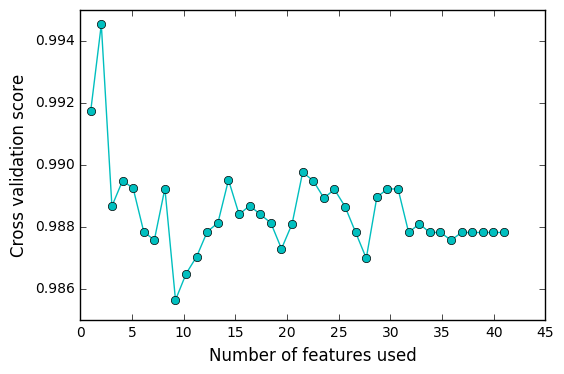

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Number of features used", fontsize = 12)
ax.set_ylabel("Cross validation score", fontsize = 12)
ax.plot(fn, myscoresvm, 'c-o')

## Part 4. Classification
Using SVM linear, adopting C = 1.0, using the best 2 features.

In [20]:
clf = svm.SVC(C=1.,kernel='linear',class_weight='balanced',probability=True) 
# select features and format labeled data
featureSelector = SelectKBest(score_func=feature_selection.f_classif, k=2)
featureSelector.fit(X_labeled,Y_labeled)
ixselect = featureSelector.get_support(indices = True)
# print ixselect
print np.asarray(featurenames)[ixselect]

['ltau' 'W1mW2']


In [21]:
# Format the full, qso, and star datasets
X_labeled_new = X_labeled[:, ixselect]
X_qso_new = X_data[label_qso_ind][:, ixselect]
X_star_new = X_data[label_star_ind][:, ixselect]
X_unlabeled_new = X_data[unlabel_ind][:, ixselect]
X_new = X_data[:,ixselect]

In [22]:
nqso = X_qso_new.shape[0] 
nstar = X_star_new.shape[0] 
nall = X_new.shape[0] 
nunlabeled = X_unlabeled_new.shape[0] 
print nqso, nstar, nall, nunlabeled

50 131 6182 6001


In [24]:
nfolds = 10
kf = cross_validation.KFold(len(Y_labeled), n_folds=nfolds, shuffle=True, random_state=0)
# kf = StratifiedKFold(n_splits=10, shuffle=True)    
cm = np.zeros((2,2))
qsoprob_all = np.zeros(nall)
qsoprob_qso = np.zeros(nqso)
qsoprob_star = np.zeros(nstar)
qsoprob_unlabeled = np.zeros(nunlabeled)

for train_index, test_index in kf:
    data_train, data_test = X_labeled_new[train_index], X_labeled_new[test_index]
    target_train, target_test = Y_labeled[train_index], Y_labeled[test_index]

    # fit the training set
    clf.fit(data_train, target_train)

    # confusion matrix
    predicted = clf.predict(data_test)
    expected = target_test
    cm = cm + metrics.confusion_matrix(expected, predicted)
    
    # prob of being quasars in the full, qso, and star samples
    qsopredict_prob = clf.predict_proba(X_new)
    qsoprob_all = qsoprob_all + qsopredict_prob[:, 1]
    
    qsopredict_prob = clf.predict_proba(X_qso_new)
    qsoprob_qso = qsoprob_qso + qsopredict_prob[:, 1]
        
    qsopredict_prob = clf.predict_proba(X_star_new)
    qsoprob_star = qsoprob_star + qsopredict_prob[:, 1]
    
    qsopredict_prob = clf.predict_proba(X_unlabeled_new)
    qsoprob_unlabeled = qsoprob_unlabeled + qsopredict_prob[:, 1]


# average the probability of being quasar
qsoprob_all_norm = 1.*qsoprob_all/nfolds
qsoprob_qso_norm = 1.*qsoprob_qso/nfolds
qsoprob_star_norm = 1.*qsoprob_star/nfolds
qsoprob_unlabeled_norm = 1.*qsoprob_unlabeled/nfolds

In [25]:
labels = ['others', 'quasars']
cm2 = np.zeros((2,2))
cm2[0, :] = 1.*cm[0, :]/cm[0,:].sum()
cm2[1, :] = 1.*cm[1, :]/cm[1,:].sum()
print(cm)
print(cm2)

[[ 130.    1.]
 [   0.   50.]]
[[ 0.99236641  0.00763359]
 [ 0.          1.        ]]


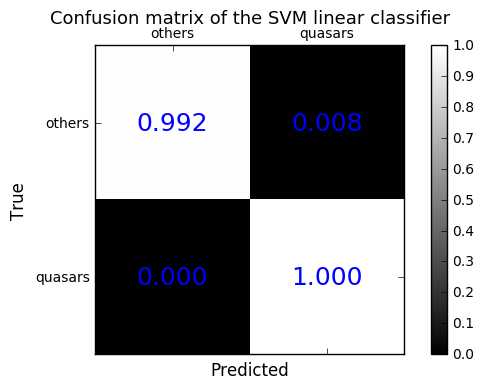

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm2, cmap='gray', vmin=0, vmax=1)
ax.set_title('Confusion matrix of the SVM linear classifier',fontsize=13)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
for i in range(2):
    for j in range(2):
        ax.text(j, i, '%.3f' % (cm[i,j]/cm[i,:].sum()), horizontalalignment='center', 
                verticalalignment='center', fontsize = 18, color='blue')
plt.tight_layout()